# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!

+ To transform your solution in a Fully Convolutional Network (FCN) to make it independent of the input image size!

    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

--2022-12-02 19:25:55--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-12-02 19:25:56--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2022-12-02 19:25:57 ERROR 404: Not Found.

--2022-12-02 19:25:58--  https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xzm5f5vrx6jwqui/training.csv [following]
--2022-12-02 19:25:59--  https://www.dropbox.com/s/raw/xzm5f5vrx6jw

> I don't know what happened here but I had some problems when trying to upload the data sets. This produced some drawbacks during the implementation process using Colab or Kaggle's GPU to conduct the GPU computation in a more optimal way. Then I had some problems when implementing the code causing a reduction on the number of different attemps I would have liked to conduct in order to compare different tricks and modified parameters. \
I tried with the local computer but it took half a day for a computation, so I finally solved it as follows: 

In [2]:
FTRAIN = '/kaggle/input/face-key-point/training.csv'
FTEST = '/kaggle/input/face-key-point/test.csv'
FLOOKUP = 'IdLookupTable.csv'



In [3]:

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

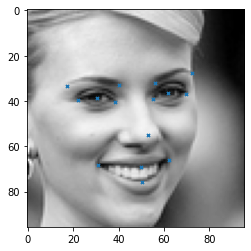

In [4]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [5]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


## Baseline model:

I firstly tried to add an additional convolutional layer in order to improve the accuracy of the pixels predicted. I tried different combinations of dimensions ending up with the most efficient ones given by a pyramid structure: $2^6, 2^7, 2^8$, and the fixed one of $2^7$. I've also applied different kernel sizes, decreasing in the layers used. \
\ 
Using this pyramid configuration I've reached pixel error of around to $\bf{1.45}$, when fitting the model to a training set and then applying it to predict the corresponding values of $\hat{y}$ for the test set. I've used a batch size of 30, and 50 epochs. \
\
However, after applying additional tricks that may be discussed subsequently, I've also tried a different layout, which consisted of forming fully convolutional layers with two 2d convolutional layers together, then a max pooling separating each layer. Using this model without hardly any modification I've attained around $\bf{1.41}$ pixel error. 

## Addicional tricks

I've also applied different strategies to improve the accuracy of the model:
- In order to avoid overfitting I've added a **dropout** of the 25% after the last convolutional layer, in order to reduce the dimension as a regularization technique. The pixel error improved, but when increasing too much this dropout ratio the results were worse. 
- I've also tried Batchnormalizations after the convolutional layers to improve the accuracy or intern dropout but it didn't improve the pixel error. 
- I've tried to modify the learning rate and the momentum:
    - When decresing the learning rate it seemed to work more accurately but the stepsize per iteration was smaller and therefore, the model need more epochs to obtain satisfactory results, which is not computationally affordable at all. 
    - When changing the momentum, if fixing it bigger, the loss sometimes kept increasing when going through iterations! When fixed too small, the optimization method didn't attain the minimum correctly. 
- However, I've relized that once I had an optimal setting of the model's baseline, and additional tricks, I could retrain the model (which was already trained with the training set) with the training set again, but setting a smaller learning rate so the optimization process would be more precise (I don't actually know how legal this is) but it worked, leading to a pizel error of $\bf{0.33}$ and sometimes even bellow!

## Augmented data

Finally, once setted the optimal models, which were the both described before, and that may be implemented sbsequently, I've tried some data augmentation in order to increase the size of my training data set. I've tried:
- Horizontal flip
- Manually increasing the contrast (which didn't work at all)

However, when adding one, or both of the augmented data to the fixed model, the results obtained where worse than the previous ones. 

Then the results obtained are shown as follows: 


## Modifying initial baseline:

In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1) ## (None, None, 1) and take out the Dense
output_shape = 30

## Without the augmented data, retraining the model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Dropout(0.1),
        #layers.BatchNormalization(),
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Conv2D(64*2, kernel_size=(3, 3), activation="relu", padding="same"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dense(64, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 128)       131200    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dense_2 (Dense)              (None, 12, 12, 64)       

In [9]:
batch_size = 128
epochs = 50
from tensorflow.keras.optimizers import SGD, Adam

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

#model.compile(loss=root_mean_squared_error, optimizer="adam")
#model.compile(loss=root_mean_squared_error, optimizer=SGD(lr=1e-4, momentum=0.9))
model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-3, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,))



model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0589 - val_loss: 0.0407
Epoch 2/50
11/11 [==============================] - 1s 48ms/step - loss: 0.0335 - val_loss: 0.0333
Epoch 3/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0274 - val_loss: 0.0339
Epoch 4/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0261 - val_loss: 0.0311
Epoch 5/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0244 - val_loss: 0.0316
Epoch 6/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0236 - val_loss: 0.0310
Epoch 7/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0232 - val_loss: 0.0317
Epoch 8/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0231 - val_loss: 0.0313
Epoch 9/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0230 - val_loss: 0.0312
Epoch 10/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0218 - val_loss: 0.0304
Epoch 11/

In [10]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.4596308


In [11]:
model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-4, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,))



model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 1s 64ms/step - loss: 0.0151 - val_loss: 0.0291
Epoch 2/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0140 - val_loss: 0.0287
Epoch 3/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0138 - val_loss: 0.0287
Epoch 4/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0135 - val_loss: 0.0288
Epoch 5/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0136 - val_loss: 0.0287
Epoch 6/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0135 - val_loss: 0.0288
Epoch 7/50
11/11 [==============================] - 1s 49ms/step - loss: 0.0135 - val_loss: 0.0288
Epoch 8/50
11/11 [==============================] - 1s 50ms/step - loss: 0.0133 - val_loss: 0.0289
Epoch 9/50
11/11 [==============================] - 1s 52ms/step - loss: 0.0134 - val_loss: 0.0288
Epoch 10/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0133 - val_loss: 0.0288
Epoch 11/

In [12]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  1.3968502


## Putting together two 2d convolutional layers

Proofs when adding together two convolutional layer consecutive, and then a Maxpooling, then 2 layers more together:
- At first it seemed to work better.
- I've tried 4 layers with 2 convolutional layers consecutive, followed by a MaxPooling per pack. Then at the end we have the dense. Dimensions increase from 64 to 64*2 and kernel size decreases from 5 to 3. 

Other strategies followed, again:
- In this situation I've tried again the Dropout at the end to reduce dimensionality: error decreases for 25%. Trying greater percentages and it looks like it improves. Left at 0.25 in the end, less volatile. 
- Dropout after layers: worse error
- Batchnormalization after layers: worse
- Adding a dense layer with relu activation function previous to the final dropout and the classification layer: it decreased the pixel error in fact.

In [13]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


# Predefined parameters
input_shape = (96, 96, 1) ## (None, None, 1) and take out the Dense
output_shape = 30

## Without the augmented data, retraining the model

model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        ## Fully connected layer 1
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        
        ## Fully connected layer 2
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dense(64, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 64)        102464    
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 96, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 128)       131200    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 128)      

In [14]:
batch_size = 128
epochs = 50
from tensorflow.keras.optimizers import SGD, Adam

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))



model2.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-3, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,))



model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 6s 322ms/step - loss: 0.3233 - val_loss: 0.3051
Epoch 2/50
11/11 [==============================] - 2s 155ms/step - loss: 0.1276 - val_loss: 0.2725
Epoch 3/50
11/11 [==============================] - 2s 152ms/step - loss: 0.0885 - val_loss: 0.2197
Epoch 4/50
11/11 [==============================] - 2s 151ms/step - loss: 0.0786 - val_loss: 0.1831
Epoch 5/50
11/11 [==============================] - 2s 152ms/step - loss: 0.0747 - val_loss: 0.1602
Epoch 6/50
11/11 [==============================] - 2s 150ms/step - loss: 0.0729 - val_loss: 0.1519
Epoch 7/50
11/11 [==============================] - 2s 151ms/step - loss: 0.0718 - val_loss: 0.1449
Epoch 8/50
11/11 [==============================] - 2s 152ms/step - loss: 0.0701 - val_loss: 0.1434
Epoch 9/50
11/11 [==============================] - 2s 153ms/step - loss: 0.0690 - val_loss: 0.1410
Epoch 10/50
11/11 [==============================] - 2s 152ms/step - loss: 0.0689 - val_loss: 0.1304

In [15]:
y_new2 = model2.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new2))

Mean pixel error:  1.690948


Let's try one more layer and previous batchnormalization:

In [19]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


# Predefined parameters
input_shape = (96, 96, 1) 
output_shape = 30

## Without the augmented data, retraining the model

model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        layers.BatchNormalization(),
        
        ## Fully connected layer 1
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        #layers.Dropout(0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        
        ## Fully connected layer 2
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        
        ## Fully connected layer 3
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        
        ## Fully connected layer 4
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        ##layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dense(64, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 96, 96, 64)        1664      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 96, 96, 64)        102464    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 48, 48, 128)       131200    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 48, 48, 128)       262272    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 128)      

In [20]:
batch_size = 128
epochs = 50
from tensorflow.keras.optimizers import SGD, Adam

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))



model3.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-3, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,))



model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 3s 180ms/step - loss: 0.3121 - val_loss: 0.2343
Epoch 2/50
11/11 [==============================] - 2s 146ms/step - loss: 0.1072 - val_loss: 0.0863
Epoch 3/50
11/11 [==============================] - 2s 145ms/step - loss: 0.0803 - val_loss: 0.0713
Epoch 4/50
11/11 [==============================] - 2s 148ms/step - loss: 0.0762 - val_loss: 0.0678
Epoch 5/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0735 - val_loss: 0.0663
Epoch 6/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0724 - val_loss: 0.0663
Epoch 7/50
11/11 [==============================] - 2s 147ms/step - loss: 0.0724 - val_loss: 0.0663
Epoch 8/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0713 - val_loss: 0.0664
Epoch 9/50
11/11 [==============================] - 2s 145ms/step - loss: 0.0708 - val_loss: 0.0663
Epoch 10/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0713 - val_loss: 0.0664

In [21]:
y_new3 = model3.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new3))

Mean pixel error:  1.4425157


In [22]:
model3.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-4, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,))



model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 2s 163ms/step - loss: 0.0249 - val_loss: 0.0276
Epoch 2/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0238 - val_loss: 0.0276
Epoch 3/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0234 - val_loss: 0.0277
Epoch 4/50
11/11 [==============================] - 2s 147ms/step - loss: 0.0233 - val_loss: 0.0275
Epoch 5/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0228 - val_loss: 0.0274
Epoch 6/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0228 - val_loss: 0.0272
Epoch 7/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0227 - val_loss: 0.0273
Epoch 8/50
11/11 [==============================] - 2s 147ms/step - loss: 0.0225 - val_loss: 0.0274
Epoch 9/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0226 - val_loss: 0.0274
Epoch 10/50
11/11 [==============================] - 2s 146ms/step - loss: 0.0224 - val_loss: 0.0278

In [23]:
y_new3 = model3.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new3))

Mean pixel error:  1.335622


## Finally trying out the augmented data:

In [24]:
x_train2 = np.zeros((x_train.shape[0],96,96,1))
y_train2 = np.zeros((y_train.shape[0],30,))

for k in range(0, x_train.shape[0]):
    for i in range(0, 96):
        for j in range(0,96):
            x_train2[k][i,j,0] = x_train[k][i, 95-j, 0]
    y_train2[k][0::2] = -y_train[k][0::2]
    y_train2[k][1::2] = y_train[k][1::2] 

In [25]:
x_train_new = np.zeros((2*x_train.shape[0], 96, 96, 1))
y_train_new = np.zeros((2*y_train.shape[0], 30, ))
x_train_new[:x_train.shape[0]]=x_train
x_train_new[x_train.shape[0]:] = x_train2
y_train_new[:y_train.shape[0]] = y_train
y_train_new[y_train.shape[0]:] = y_train2

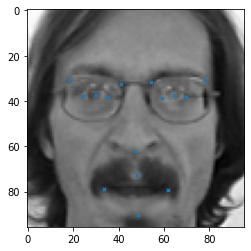

In [26]:
plot_sample(x_train_new[-1],y_train_new[-1])

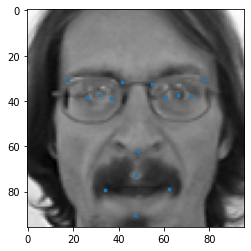

In [27]:
plot_sample(x_train_new[x_train.shape[0]-1],y_train_new[x_train.shape[0]-1])

In [33]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


# Predefined parameters
input_shape = (96, 96, 1) ## (None, None, 1) and take out the Dense
output_shape = 30

## Without the augmented data, retraining the model

model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        ## Fully connected layer 1
        layers.BatchNormalization(),
        
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(2**6, kernel_size=(5, 5), activation="relu", padding="same"),
        #layers.Dropout(0.1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        
        ## Fully connected layer 2
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64*4, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        #layers.Conv2D(64*4, kernel_size=(5, 5), activation="relu", padding="same"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dense(64, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 96, 96, 64)        1664      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 96, 96, 64)        102464    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 128)       131200    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 48, 48, 128)       262272    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 128)      

In [34]:
model4.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-3, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,))



model4.fit(x_train_new, y_train_new, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
22/22 [==============================] - 5s 164ms/step - loss: 0.3826 - val_loss: 0.3209
Epoch 2/50
22/22 [==============================] - 3s 150ms/step - loss: 0.2775 - val_loss: 0.3000
Epoch 3/50
22/22 [==============================] - 3s 150ms/step - loss: 0.2744 - val_loss: 0.3045
Epoch 4/50
22/22 [==============================] - 3s 150ms/step - loss: 0.2744 - val_loss: 0.2957
Epoch 5/50
22/22 [==============================] - 3s 153ms/step - loss: 0.2736 - val_loss: 0.2869
Epoch 6/50
22/22 [==============================] - 3s 151ms/step - loss: 0.2739 - val_loss: 0.3067
Epoch 7/50
22/22 [==============================] - 3s 152ms/step - loss: 0.2733 - val_loss: 0.2946
Epoch 8/50
22/22 [==============================] - 3s 152ms/step - loss: 0.2732 - val_loss: 0.3029
Epoch 9/50
22/22 [==============================] - 3s 150ms/step - loss: 0.2723 - val_loss: 0.2840
Epoch 10/50
22/22 [==============================] - 3s 150ms/step - loss: 0.2678 - val_loss: 0.3114

In [35]:
y_new4 = model4.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new4))

Mean pixel error:  7.121919


Note then that the result obteined by adding the augmented data provides worse pixel error. This could be because the model is not fixed to the complexity of the augmented data and we may have to modify the model to addapt and fit correctly the new training data set that is being provided to the model. In order to do so I could improve the model by adding more layers (maybe two more) or rather by increasin the dimension in the pyramid structure of the layers we already have in the model. 

# Fully convolutional layer:

Now we seek to transform our model to an independent model from the input's shape. In order to do so we may fix the input shape to `(None, None, 1)` and take all the dense layers out of the model:

In [36]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


# Predefined parameters
input_shape = (None, None, 1) 
output_shape = 30

model5 = keras.Sequential(
    [
        
        keras.Input(shape=input_shape),
        
        ## Fully connected layer 1
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        #layers.GlobalMaxPooling2D(),
        
        ## Fully connected layer 2
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        layers.Conv2D(64*2, kernel_size=(4, 4), activation="relu", padding="same"),
        #layers.GlobalMaxPooling2D(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.GlobalMaxPooling2D(),
        
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64*4, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.GlobalMaxPooling2D(),
        
        #layers.Dropout(0.25),
        layers.Conv2D(output_shape, kernel_size=(5, 5), activation="linear"),
        layers.GlobalMaxPooling2D(),
        #layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        #layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Dense(64, activation="relu"),
        #layers.Flatten(),
        #layers.Dropout(0.25),
        #layers.Dense(output_shape, activation="linear"),
    ]
)

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 96, 96, 64)        1664      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 96, 96, 64)        102464    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 48, 48, 128)       131200    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 48, 48, 128)       262272    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 128)      

In [37]:
model5.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-3, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,))



model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 3s 181ms/step - loss: 0.4266 - val_loss: 0.3558
Epoch 2/50
11/11 [==============================] - 2s 157ms/step - loss: 0.1855 - val_loss: 0.2102
Epoch 3/50
11/11 [==============================] - 2s 157ms/step - loss: 0.0902 - val_loss: 0.1904
Epoch 4/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0732 - val_loss: 0.1537
Epoch 5/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0712 - val_loss: 0.1416
Epoch 6/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0677 - val_loss: 0.1334
Epoch 7/50
11/11 [==============================] - 2s 158ms/step - loss: 0.0671 - val_loss: 0.1246
Epoch 8/50
11/11 [==============================] - 2s 157ms/step - loss: 0.0668 - val_loss: 0.1193
Epoch 9/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0666 - val_loss: 0.1293
Epoch 10/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0669 - val_loss: 0.1188

In [39]:
y_new5 = model5.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new5))


Mean pixel error:  2.2951899


In [40]:
model5.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=1e-4, beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,))



model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 2s 171ms/step - loss: 0.0241 - val_loss: 0.0404
Epoch 2/50
11/11 [==============================] - 2s 159ms/step - loss: 0.0216 - val_loss: 0.0385
Epoch 3/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0209 - val_loss: 0.0381
Epoch 4/50
11/11 [==============================] - 2s 157ms/step - loss: 0.0206 - val_loss: 0.0371
Epoch 5/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0204 - val_loss: 0.0369
Epoch 6/50
11/11 [==============================] - 2s 156ms/step - loss: 0.0201 - val_loss: 0.0361
Epoch 7/50
11/11 [==============================] - 2s 158ms/step - loss: 0.0199 - val_loss: 0.0356
Epoch 8/50
11/11 [==============================] - 2s 157ms/step - loss: 0.0196 - val_loss: 0.0354
Epoch 9/50
11/11 [==============================] - 2s 157ms/step - loss: 0.0193 - val_loss: 0.0350
Epoch 10/50
11/11 [==============================] - 2s 159ms/step - loss: 0.0191 - val_loss: 0.0347

In [41]:
y_new5 = model5.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new5))



Mean pixel error:  1.5149262


# Reporting

Please, report the results of your experiments in this cell.



## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is $\bf{1.335622}$

## What architecture and tricks you used for that result?

### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**:
> After trying the different architectures and strategies described previously, the optimal result was obtained with a convolutional layer that consisted of 4 fully connected layers with two 2 dimensional convolutional layers together, all of them with `relu` activation function and a Max pooling. The dimension of the convolutional layers inside each block was the same, and when regarding the rest of the model it had a pyramid structure, this is, increasing values for the dimension, all of them potences of 2. Meanwhile, the kernel size had a decreasing pyramid structure, from 5 to 3. \
Additionally, a batch normalization was added previous to the layers, and a dropout of 25% at the end, along with the corresponding dense layer and followed up finally by the classification layer, using a linear activation function.\
Finally, I've added an additional retraining of the training data set, using the already trained model, and modifying the learning rate (and in some cases the momentum of the fitting model). This way, the optimization and fitting could be modified and adjusted to how close we were from the real values when predicting. \
Some different loss function (such as the focal loss function `tfa.losses.SigmoidFocalCrossEntropy()`, or the Mean squared logarithmic function, `tfa.losses.MeanSquaredLogarithmicError()`) have been tried, providing worse results. Similarly, different activation function such as elu, selu, tanh, have also been tried, also with nonimproving results. 



## What is the architecture of your FCN?

> The architecture of the FCN model I've implemented is the same as the optimal CNN model, but without specifying the dimensions of the input and taking out all the dense layers. 

### Insert one of the test images in a larger image and show the detection result. The size of the face cannot change!


(321, 96, 96, 1)
(321, 30)


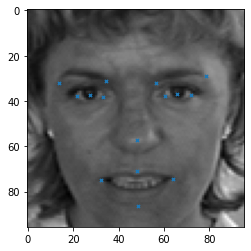

In [54]:
print(x_valid.shape)
print(y_valid.shape)
plot_sample(x_valid[-1,:,:,0],y_valid[-1])

In [61]:
x_larger = np.zeros((1,x_valid.shape[1]*2, x_valid.shape[2]*2, 1))
x_larger[0,:x_valid.shape[1], :x_valid.shape[1], 0] = x_valid[-1, :, :, 0]
y_larger = np.zeros((y_valid.shape[1]*2,1))
y_larger[:y_valid.shape[1], 0] = y_valid[-1]
print(x_larger.shape)

(1, 192, 192, 1)


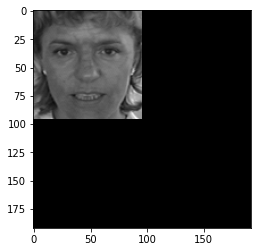

In [63]:
pyplot.imshow(x_larger[0], cmap='gray')

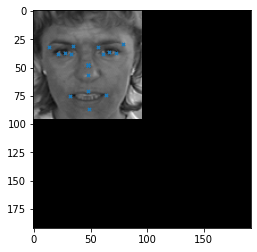

In [65]:
plot_sample(x_larger[0],y_larger)

In [64]:
y_new6 = model5.predict(x_larger)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_larger, y_new6))




Mean pixel error:  20.680895625878797


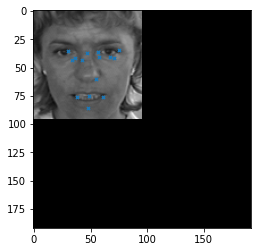

In [67]:
plot_sample(x_larger[0],y_new6[0])

When inserting an image of the test data set into a larger image and using the FCN to detect the points of the face, the pixel error obteined is quite big. However, when plotting the detected points it is a quite acceptable prediction of the face's points taking into account that the image is located in a corner of the given sample. 

## Annexes of the results obained: visual representation of the face's points detected with the different architectures:

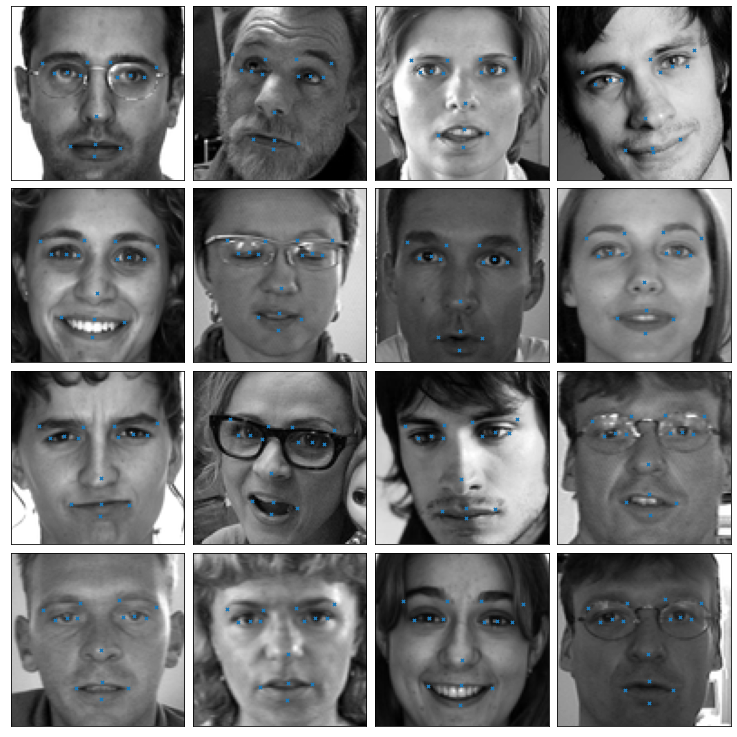

In [44]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new2[i])
pyplot.show()

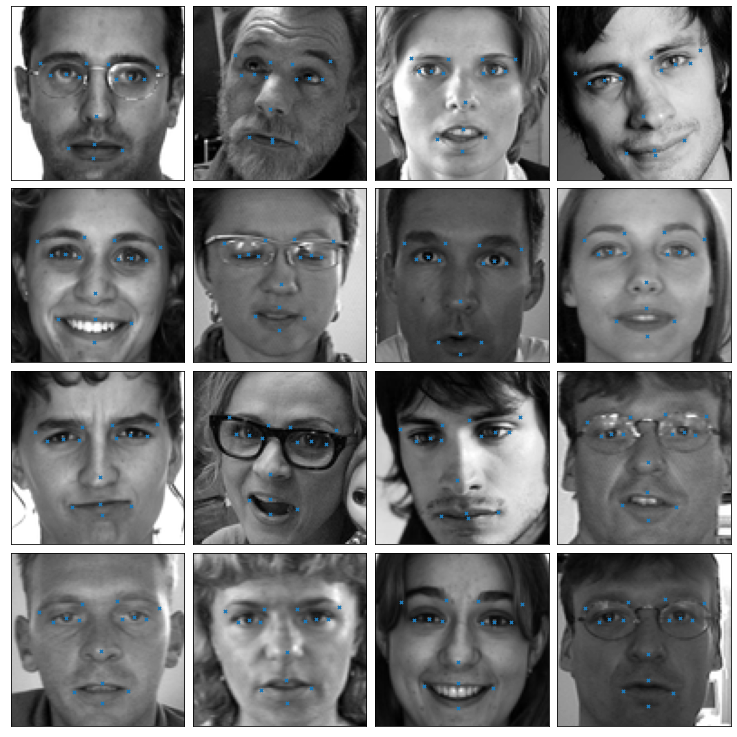

In [46]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new3[i])
pyplot.show()

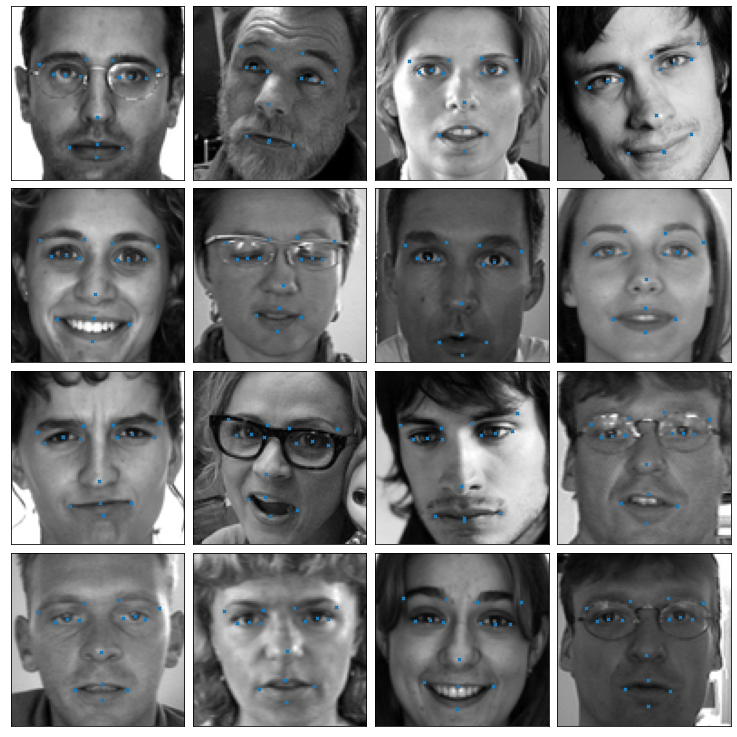

In [43]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

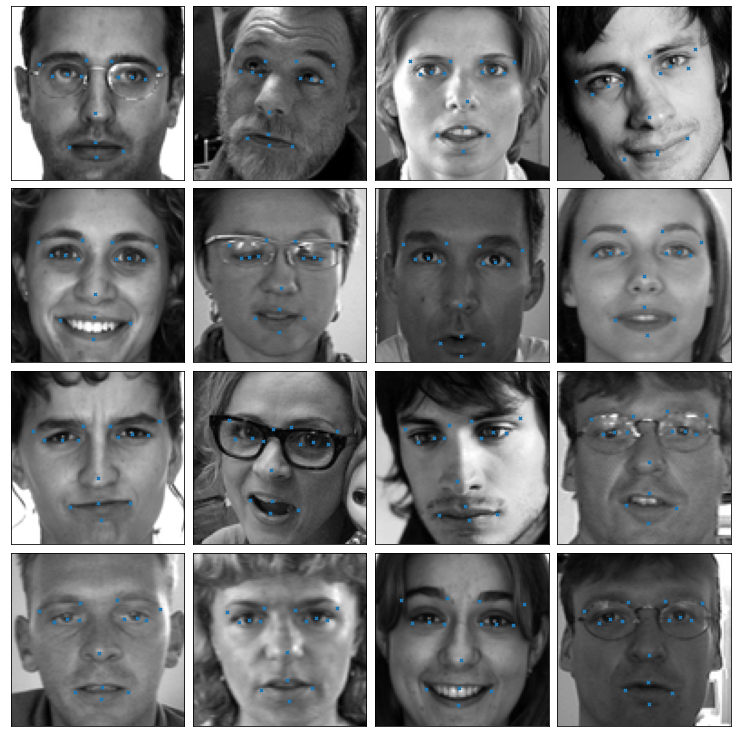

In [47]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new5[i])
pyplot.show()